In [1]:
import numpy as np
import pandas as pd

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder


# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

trn = pd.read_csv('Data/train.csv')
tst = pd.read_csv('Data/test.csv')
n_trn = len(trn)
df = pd.concat([trn, tst])
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# Modify features

PassengerId and Ticket are highly unlikely to be relevant, so delete them. Also delete Cabin because most values are mising. Additionally, recode Sex as 'm'/'f'.

In [2]:
df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.Sex.replace(['male', 'female'], ['m', 'f'], inplace=True)
df.Survived.replace([1, 0], [True, False], inplace=True)
df.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,m,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,f,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,f,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,f,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,m,0,0.0


## Imputation

First, see how many values are missing in each column.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Age         1046 non-null float64
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(3), int64(3), object(3)
memory usage: 102.3+ KB


Embarked and Fare are missing very few values. Simply fill these with the appropriate mode and relevant median, respectively, after inspection.

In [4]:
# Display table with counts for each value of Embarked
print(df['Embarked'].value_counts())
# Value 'S' is by far the most common, so set the missing values to S.
df['Embarked'].fillna('S', inplace=True)


S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [5]:
# Get row of passenger with fare information missing
df[df['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
152,60.5,S,NaN,"Storey, Mr. Thomas",0,3,m,0,NaN


In [6]:
# Get median fare paid by passengers in the same class, from the same destination and place it.
median_fare = df[np.logical_and(df['Pclass']==3, df['Embarked']=='S')]['Fare'].median()
median_fare = df[np.logical_and(df['Pclass']==3, df['Embarked']=='S')]['Fare'].median()
df['Fare'].fillna('S', inplace=True)
# Check only Survived (naturally only has values for training set) and Age (to be done later, if at all) have missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Age         1046 non-null float64
Embarked    1309 non-null object
Fare        1309 non-null object
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 102.3+ KB


In [7]:
# Embarked would likely only be relevant in so far as it is an indicator of socioeconomic class. But since we now have complete
# information for Fare as well as Pclass, we can discard it.
df.drop(['Embarked'], axis=1, inplace=True)

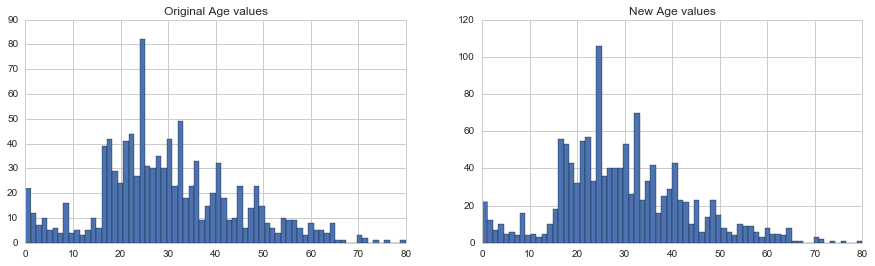

In [8]:
# Fill in missing age values by sampling randomly from the existing values.

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values')
axis2.set_title('New Age values')

# get average, std, and number of NaN values in df
average_age   = df["Age"].mean()
std_age      = df["Age"].std()
count_nan_age = df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)

# plot original Age values
# NOTE: drop all null values, and convert to int
df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
df.loc[np.isnan(df["Age"]), "Age"] = rand_1

# convert from float to int
df['Age'] = df['Age'].astype(int)
        
# plot new Age Values
df['Age'].hist(bins=70, ax=axis2)

In [9]:
# Check all missing values have been taken care of
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
Age         1309 non-null int32
Fare        1309 non-null object
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 86.9+ KB


# Some exploratory plots
Make some plots to gain intuition about suitable models

Would be better to have sample sizes for each plot in titles.


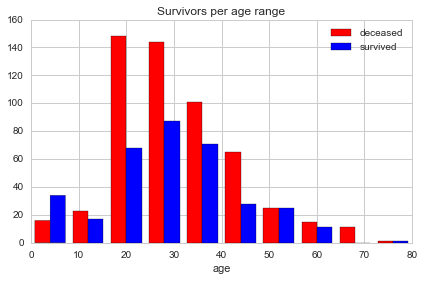

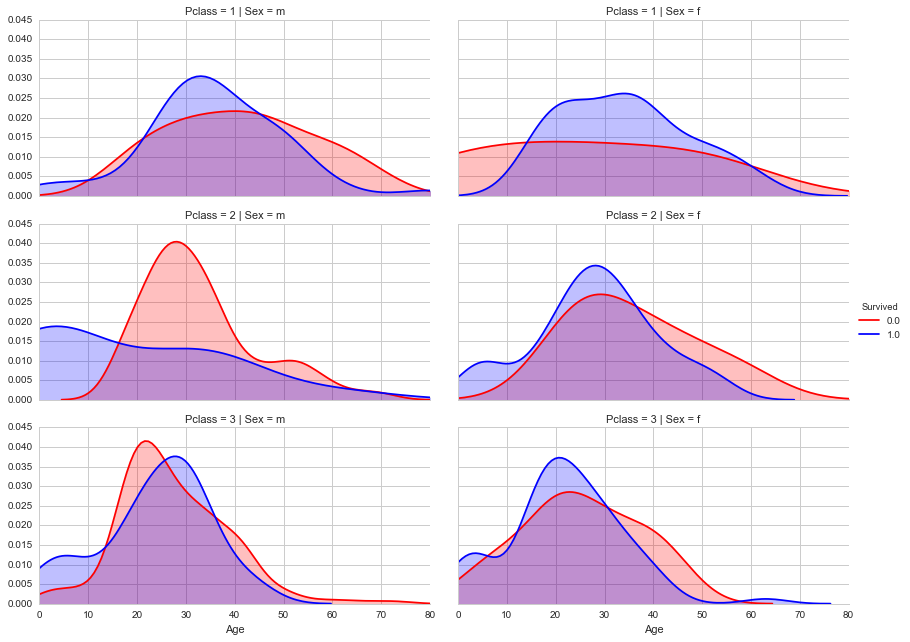

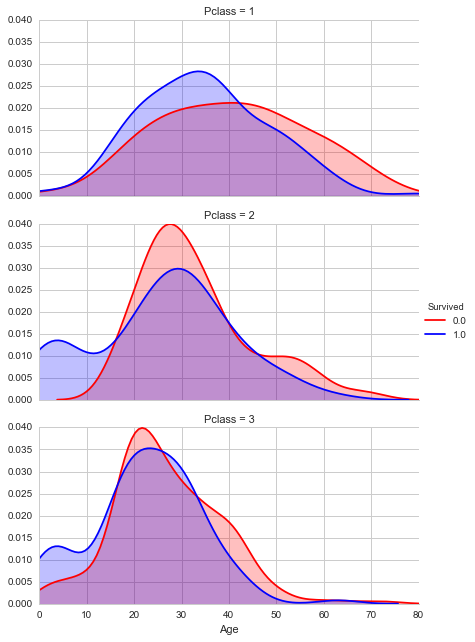

In [10]:
df_trn = df[:n_trn]

n_bins = 10
x1 = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==0, -np.isnan(df_trn['Age']))])
x2 = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==1, -np.isnan(df_trn['Age']))])
x_hist=[x1,x2]

# fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,5))
plt.figure()

colors = ['red', 'blue']
plt.hist(x_hist, n_bins, normed=0, histtype='bar', color=colors, label=['deceased', 'survived'])
plt.legend(prop={'size': 10})
plt.title('Survivors per age range')
plt.xlabel('age')
plt.tight_layout()

# Seaborn Facets
# plt.figure(figsize=(5,3))

# peaks for survived/not survived passengers by their age


facet = sns.FacetGrid(df_trn, row='Pclass', col='Sex', hue="Survived", aspect=2, palette=['red','blue'])
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_trn['Age'].max()))
facet.add_legend()


facet = sns.FacetGrid(df_trn, row='Pclass', hue="Survived", aspect=2, palette=['red','blue'])
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_trn['Age'].max()))
facet.add_legend()


#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))

#x1m = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==0, -np.isnan(df_trn['Age']))])
#x2f = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==1, -np.isnan(df_trn['Age']))])
#x=[x1,x2]

#plt.subplot(121)
#plt.hist(x, n_bins, normed=0, histtype='bar', color=colors, label=['deceased', 'survived'])
#plt.legend(prop={'size': 10})
#plt.title('Survivors per age range')
#plt.xlabel('age')
#plt.tight_layout()


print('Would be better to have sample sizes for each plot in titles.')


# Logistic regression
## Naive
A univariate logstic regression for survival as a function of age should not work well based on the graphs above, at least without a transformation. Try it as a point of reference.

In [11]:
x = df_trn['Age'].reshape(-1,1)
y = df_trn['Survived'].ravel()

logreg1 = LogisticRegression()
logreg1.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
print("Model score: " + str(logreg1.score(x, y)))

Model score: 0.616161616162


A score of 61% seems rather low (but was expected). Have a look at the null error rate:

In [13]:
df_trn['Survived'].mean()

0.3838383838383838

This suggests the model is simply predicting survival for noone. Inspect the coefficients to confirm:

In [14]:
print(" Age coefficient: " + str(logreg1.coef_[0, 0]))
print(" Intercept: " + str(logreg1.intercept_[0]))

 Age coefficient: -0.00957709213624
 Intercept: -0.192996416054


Indeed, this clearly results in negative predictions for all (positive) ages.

## Quadratic in Age
The histogram of survival by age above suggests a quadratic function on age is likely a much better predictor for survival. Cubic would likely be better still, but is not considered here.

In [15]:
# Now do logistic regression again, but with the quadratic age term added
logreg2 = make_pipeline(PolynomialFeatures(2, include_bias = False), LogisticRegression())
logreg2.fit(x,y)

#logreg2.fit(poly_x, y)
print("Model score: " + str(logreg2.score(x, y)))

Model score: 0.616161616162


This is technically an improvement, but a tiny one. Inspect the coefficients:

In [16]:
print(" Age coefficients: " + str(logreg2.steps[1][1].coef_))
print(" Intercept: " + str(logreg2.steps[1][1].intercept_[0]))


 Age coefficients: [[-0.02848324  0.00033356]]
 Intercept: -0.00139497265746


## Linear in Age, with Class and Sex included

In [17]:
sex_column = df_trn['Sex'].copy()
sex_column.replace({'m': 0, 'f': 1}, inplace = True)
df_trn = pd.concat([df_trn.drop('Sex', axis=1).copy(), sex_column], axis=1)
;

''

In [18]:
df_trn.head(3)

,Age,Fare,Name,Parch,Pclass,SibSp,Survived,Sex
0,22,7.25,"Braund, Mr. Owen Harris",0,3,1,0.0,0
1,38,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1,1.0,1
2,26,7.925,"Heikkinen, Miss. Laina",0,3,0,1.0,1


In [19]:
x_a_ndarray = df_trn.loc[:,'Age'].copy().reshape(-1,1)
x_a = pd.DataFrame(data = x_a_ndarray, columns = ['Age'])

OneHotEncoder(categorical_features='all', dtype=<class 'float'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [20]:
# Create a dataframe holding the one-hot-encoded terms for Class and Sex
onehotenc_cs = OneHotEncoder(sparse=False)
x_cs_ndarray = onehotenc_cs.fit_transform(df_trn.loc[:,['Pclass', 'Sex']].copy())
x_cs = pd.DataFrame(data = x_cs_ndarray, columns = ['Class 1', 'Class 2', 'Class 3', 'male','female'])

x_acs = pd.concat([x_a, x_cs], axis=1)

In [21]:
logreg3 = LogisticRegression(C=1000000.0)
logreg3.fit(x_acs, y)
print("Model score: " + str(logreg3.score(x_acs, y)))

Model score: 0.79012345679


In [22]:
x_acs.head()

,Age,Class 1,Class 2,Class 3,male,female
0,22,0.0,0.0,1.0,1.0,0.0
1,38,1.0,0.0,0.0,0.0,1.0
2,26,0.0,0.0,1.0,0.0,1.0
3,35,1.0,0.0,0.0,0.0,1.0
4,35,0.0,0.0,1.0,1.0,0.0


This is significantely better. Now add a quadratic term for age (a quadratic term for class or sex is nonsensical as these are (one hot) categorical variables.
## Quadratic in Age, with Class and Sex included

In [23]:
# Create a dataframe holding the linear and quadratic term in Age
temp_age = df_trn['Age'].copy().reshape(-1,1)
poly_feat = PolynomialFeatures(2, include_bias=False)
x_a2_ndarray = poly_feat.fit_transform(temp_age)
x_a2 = pd.DataFrame(data = x_a2_ndarray, columns = ['Age', 'Age^2'])

In [24]:
x_a2cs = pd.concat([x_a2, x_cs], axis=1)
x_a2cs.head(3)

,Age,Age^2,Class 1,Class 2,Class 3,male,female
0,22.0,484.0,0.0,0.0,1.0,1.0,0.0
1,38.0,1444.0,1.0,0.0,0.0,0.0,1.0
2,26.0,676.0,0.0,0.0,1.0,0.0,1.0


In [25]:
logreg4 = LogisticRegression(C=1000000.0)
logreg4.fit(x_a2cs, y)
print("Model score: " + str(logreg4.score(x_a2cs, y)))

Model score: 0.786756453423


In [26]:
logreg4.coef_

array([[ -5.28746216e-02,   3.68572767e-04,   1.33670886e+00,
          2.70442827e-01,  -9.22641635e-01,  -9.55854318e-01,
          1.64036437e+00]])

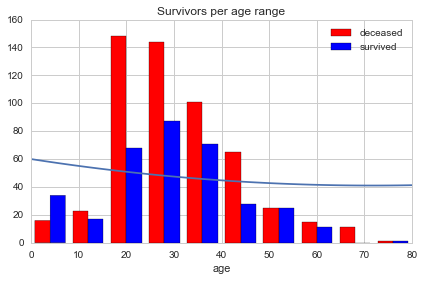

In [63]:
# Plot the fitted quadratic function of Age
fig = plt.figure()
ax = fig.add_subplot(111)

plt.hist(x_hist, n_bins, normed=0, histtype='bar', color=colors, label=['deceased', 'survived'])
plt.legend(prop={'size': 10})
plt.title('Survivors per age range')
plt.xlabel('age')
plt.tight_layout()

line_x = np.arange(0, 81, 1)
line_y = line_x * logreg4.coef_[0][0] + np.power(line_x,2) * logreg4.coef_[0][1] 
plt.plot(line_x,60+10*line_y)


# First Prediction
Since the quadratic term did not improve the test error rate, make a first prediction using the very simple logistic regression on Age, Class and Sex.

In [64]:
x_a_pred_ndarray = df_tst.loc[:,'Age'].copy().reshape(-1,1)
x_a_pred = pd.DataFrame(data = x_a_pred_ndarray, columns = ['Age'])

onehotenc_cs_pred = OneHotEncoder(sparse=False)
x_cs_pred_ndarray = onehotenc_cs_pred.fit_transform(df_tst.loc[:,['Pclass', 'Sex']].copy())
x_cs_pred = pd.DataFrame(data = x_cs_pred_ndarray, columns = ['Class 1', 'Class 2', 'Class 3', 'male','female'])

x_acs_pred = pd.concat([x_a_pred, x_cs_pred], axis=1)
logreg3.predict

NameError: name 'df_tst' is not defined